In [1]:
import pandas as pd          
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.inspection import permutation_importance

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.concat(map(pd.read_csv, ['tennis_atp/atp_matches_2018.csv','tennis_atp/atp_matches_2019.csv', 'tennis_atp/atp_matches_2020.csv','tennis_atp/atp_matches_2021.csv','tennis_atp/atp_matches_2022.csv','tennis_atp/atp_matches_2023.csv','tennis_atp/atp_matches_2024.csv']))

In [3]:
# Remove identifying data
# Find a way to include tourney_level and score
df = df.drop(columns=['winner_id', 'winner_name', 'winner_ioc', 
                      'loser_id', 'loser_name', 'loser_ioc', 
                      'tourney_id', 'tourney_name', 'tourney_level', 
                      'tourney_date', 'match_num', 'winner_seed', 
                      'winner_entry', 'loser_seed', 'loser_entry','score', 'draw_size', 'best_of', 'round'])

In [4]:
# Check for missing values.
print(df.isnull().sum())

# There are zero duplicates no action needed
print(df.duplicated().sum())

# Drop any rows with nulls in them
df = df.dropna()

# Check total number of rows, should be over 15k
row_count = len(df)
print(row_count)

surface                 53
winner_hand              0
winner_ht               79
winner_age               3
loser_hand               1
loser_ht               227
loser_age                3
minutes               1033
w_ace                  694
w_df                   694
w_svpt                 694
w_1stIn                694
w_1stWon               694
w_2ndWon               694
w_SvGms                694
w_bpSaved              694
w_bpFaced              694
l_ace                  694
l_df                   694
l_svpt                 694
l_1stIn                694
l_1stWon               694
l_2ndWon               694
l_SvGms                694
l_bpSaved              694
l_bpFaced              694
winner_rank             79
winner_rank_points      79
loser_rank             222
loser_rank_points      222
dtype: int64
2
17547


## Convert Categorical Variables to Numerical

In [5]:
winner_encoder = LabelEncoder()
loser_encoder = LabelEncoder()
surface_encoder = LabelEncoder()
round_encoder = LabelEncoder()


df['winner_hand'] = winner_encoder.fit_transform(df['winner_hand'])
df['loser_hand'] = loser_encoder.fit_transform(df['loser_hand'])
df['surface'] = surface_encoder.fit_transform(df['surface'])
# df['round'] = round_encoder.fit_transform(df['round'])

In [6]:
# Rename values to not be associated with winner.
df = df.rename(columns={
    'winner_age': 'p1_age',
    'winner_ht': 'p1_ht',
    'winner_hand': 'p1_hand',
    'winner_rank': 'p1_rank',
    'winner_rank_points': 'p1_rank_points',
    'loser_age': 'p2_age',
    'loser_ht': 'p2_ht',
    'loser_hand': 'p2_hand',
    'loser_rank': 'p2_rank',
    'loser_rank_points': 'p2_rank_points',
    
    'w_ace': 'p1_ace',
    'w_df': 'p1_df',
    'w_svpt': 'p1_svpt',
    'w_1stIn': 'p1_1stIn',
    'w_1stWon': 'p1_1stWon',
    'w_2ndWon': 'p1_2ndWon',
    'w_SvGms': 'p1_SvGms',
    'w_bpSaved': 'p1_bpSaved',
    'w_bpFaced': 'p1_bpFaced',

    'l_ace': 'p2_ace',
    'l_df': 'p2_df',
    'l_svpt': 'p2_svpt',
    'l_1stIn': 'p2_1stIn',
    'l_1stWon': 'p2_1stWon',
    'l_2ndWon': 'p2_2ndWon',
    'l_SvGms': 'p2_SvGms',
    'l_bpSaved': 'p2_bpSaved',
    'l_bpFaced': 'p2_bpFaced'
})

swap_mask = np.random.rand(len(df)) > 0.5

swap_cols = [
    'age', 'ht', 'hand', 'rank', 'rank_points',
    'ace', 'df', 'svpt', '1stIn', '1stWon', '2ndWon', 'SvGms', 'bpSaved', 'bpFaced'
]

for col in swap_cols:
    temp = df.loc[swap_mask, f'p1_{col}'].copy()
    df.loc[swap_mask, f'p1_{col}'] = df.loc[swap_mask, f'p2_{col}']
    df.loc[swap_mask, f'p2_{col}'] = temp

df['winner'] = np.where(swap_mask, 1, 0)

print(df['winner'].value_counts())

winner
0    8854
1    8693
Name: count, dtype: int64


In [7]:
# Display the first and last few rows of the dataset.
display(df.head())
display(df.tail())

# Display the info of the dataset.
display(df.info())

# Display summary statistics of the dataset.
display(df.describe())

,surface,p1_hand,p1_ht,p1_age,p2_hand,p2_ht,p2_age,minutes,p1_ace,p1_df,...,p2_1stWon,p2_2ndWon,p2_SvGms,p2_bpSaved,p2_bpFaced,p1_rank,p1_rank_points,p2_rank,p2_rank_points,winner
0,2,1,185.0,25.6,1,188.0,30.6,123.0,9.0,2.0,...,33.0,19.0,14.0,1.0,4.0,47.0,1010.0,52.0,909.0,0
1,2,1,183.0,23.7,1,188.0,21.2,90.0,3.0,5.0,...,25.0,14.0,9.0,4.0,5.0,94.0,593.0,54.0,890.0,1
2,2,1,185.0,31.3,1,175.0,25.6,145.0,7.0,0.0,...,37.0,29.0,15.0,10.0,16.0,63.0,809.0,30.0,1391.0,0
3,2,1,183.0,18.8,1,188.0,28.0,104.0,9.0,3.0,...,33.0,17.0,11.0,4.0,6.0,208.0,245.0,44.0,1055.0,0
4,2,1,188.0,19.9,0,193.0,27.2,69.0,5.0,4.0,...,28.0,5.0,9.0,0.0,2.0,175.0,299.0,68.0,755.0,0


,surface,p1_hand,p1_ht,p1_age,p2_hand,p2_ht,p2_age,minutes,p1_ace,p1_df,...,p2_1stWon,p2_2ndWon,p2_SvGms,p2_bpSaved,p2_bpFaced,p1_rank,p1_rank_points,p2_rank,p2_rank_points,winner
3064,2,1,175.0,25.0,1,183.0,28.2,87.0,1.0,2.0,...,19.0,5.0,8.0,5.0,9.0,569.0,64.0,819.0,24.0,0
3066,2,1,188.0,28.8,1,178.0,31.0,65.0,3.0,2.0,...,30.0,11.0,9.0,4.0,4.0,900.0,18.0,279.0,205.0,1
3068,0,0,185.0,23.9,1,188.0,21.8,137.0,1.0,2.0,...,24.0,18.0,12.0,8.0,16.0,616.0,55.0,740.0,34.0,0
3070,0,1,175.0,34.2,0,185.0,23.9,95.0,2.0,1.0,...,33.0,6.0,8.0,6.0,11.0,136.0,489.0,616.0,55.0,0
3074,2,1,175.0,26.9,1,185.0,27.3,159.0,0.0,1.0,...,32.0,17.0,14.0,5.0,9.0,554.0,67.0,416.0,109.0,0


<class 'pandas.core.frame.DataFrame'>
Index: 17547 entries, 0 to 3074
Data columns (total 31 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   surface         17547 non-null  int64  
 1   p1_hand         17547 non-null  int64  
 2   p1_ht           17547 non-null  float64
 3   p1_age          17547 non-null  float64
 4   p2_hand         17547 non-null  int64  
 5   p2_ht           17547 non-null  float64
 6   p2_age          17547 non-null  float64
 7   minutes         17547 non-null  float64
 8   p1_ace          17547 non-null  float64
 9   p1_df           17547 non-null  float64
 10  p1_svpt         17547 non-null  float64
 11  p1_1stIn        17547 non-null  float64
 12  p1_1stWon       17547 non-null  float64
 13  p1_2ndWon       17547 non-null  float64
 14  p1_SvGms        17547 non-null  float64
 15  p1_bpSaved      17547 non-null  float64
 16  p1_bpFaced      17547 non-null  float64
 17  p2_ace          17547 non-null  float

None

,surface,p1_hand,p1_ht,p1_age,p2_hand,p2_ht,p2_age,minutes,p1_ace,p1_df,...,p2_1stWon,p2_2ndWon,p2_SvGms,p2_bpSaved,p2_bpFaced,p1_rank,p1_rank_points,p2_rank,p2_rank_points,winner
count,17547.000000,17547.00000,17547.000000,17547.000000,17547.000000,17547.000000,17547.000000,17547.000000,17547.000000,17547.000000,...,17547.000000,17547.000000,17547.000000,17547.000000,17547.000000,17547.000000,17547.000000,17547.000000,17547.000000,17547.000000
mean,1.304383,0.85838,187.205733,27.164524,0.862883,187.251724,27.110560,115.207215,6.361543,2.933436,...,35.907961,15.483558,12.620391,4.139739,6.756198,78.634125,1530.084630,80.397162,1527.250755,0.495412
std,0.893933,0.34867,7.133185,4.569311,0.343981,7.059368,4.575282,42.268962,5.510838,2.456950,...,14.144409,6.845705,4.208046,3.262058,4.447991,104.466933,1719.840683,111.614961,1728.486752,0.499993
min,0.000000,0.00000,15.000000,16.500000,0.000000,15.000000,16.400000,5.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,0.000000,1.00000,183.000000,23.700000,1.000000,183.000000,23.600000,83.000000,2.000000,1.000000,...,26.000000,11.000000,10.000000,2.000000,3.000000,26.000000,644.000000,26.000000,644.000000,0.000000
50%,2.000000,1.00000,188.000000,26.800000,1.000000,188.000000,26.800000,108.000000,5.000000,2.000000,...,34.000000,15.000000,12.000000,4.000000,6.000000,55.000000,950.000000,55.000000,950.000000,0.000000
75%,2.000000,1.00000,193.000000,30.300000,1.000000,193.000000,30.200000,139.000000,9.000000,4.000000,...,44.000000,19.000000,15.000000,6.000000,9.000000,94.000000,1635.000000,94.000000,1635.000000,1.000000
max,2.000000,1.00000,211.000000,42.300000,1.000000,211.000000,42.500000,396.000000,67.000000,26.000000,...,171.000000,53.000000,50.000000,27.000000,38.000000,1921.000000,12415.000000,2146.000000,12415.000000,1.000000


In [8]:
# Check for missing values.
print(df.isnull().sum())

# There are zero duplicates
print(df.duplicated().sum())

surface           0
p1_hand           0
p1_ht             0
p1_age            0
p2_hand           0
p2_ht             0
p2_age            0
minutes           0
p1_ace            0
p1_df             0
p1_svpt           0
p1_1stIn          0
p1_1stWon         0
p1_2ndWon         0
p1_SvGms          0
p1_bpSaved        0
p1_bpFaced        0
p2_ace            0
p2_df             0
p2_svpt           0
p2_1stIn          0
p2_1stWon         0
p2_2ndWon         0
p2_SvGms          0
p2_bpSaved        0
p2_bpFaced        0
p1_rank           0
p1_rank_points    0
p2_rank           0
p2_rank_points    0
winner            0
dtype: int64
0


## Drop Nulls

In [9]:
# Drop any rows with nulls in them
df = df.dropna()

# Check 
row_count = len(df)
print(row_count)

17547


## Scale Features

In [10]:
scaler = StandardScaler()
y = df['winner'].values

X = df.drop(columns=['winner'])
scaler = StandardScaler()
X = scaler.fit_transform(X)

display(y)
display(X)

array([0, 1, 0, ..., 0, 0, 0])

array([[ 0.77817611,  0.40618312, -0.30923018, ..., -0.30241141,
        -0.254428  , -0.35769344],
       [ 0.77817611,  0.40618312, -0.58961783, ..., -0.54488264,
        -0.23650874, -0.36868603],
       [ 0.77817611,  0.40618312, -0.30923018, ..., -0.41928603,
        -0.45153981, -0.07882886],
       ...,
       [-1.45919178, -2.46194374, -0.30923018, ..., -0.85771123,
         5.90979588, -0.86393101],
       [-1.45919178,  0.40618312, -1.71116846, ..., -0.60535508,
         4.79880204, -0.85178131],
       [ 0.77817611,  0.40618312, -1.71116846, ..., -0.85073364,
         3.0068765 , -0.82053922]])

## Split data into testing and training

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
display(y_train)

array([1, 0, 0, ..., 1, 0, 1])

### Reusable function for evaluation

In [12]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

def evaluate_model(y_pred_test, y_pred_train):
  print("=== Test Metrics ===")
  accuracy_test = accuracy_score(y_test, y_pred_test)
  print(f"Accuracy: {accuracy_test}")

  precision_test = precision_score(y_test, y_pred_test, average='binary')
  print(f"Precision: {precision_test}")

  recall_test = recall_score(y_test, y_pred_test, average='binary')
  print(f"Recall: {recall_test}")

  f1_test = f1_score(y_test, y_pred_test, average='binary')
  print(f"F1 Score: {f1_test}")

  print("\n=== Training Metrics ===")
  accuracy_train = accuracy_score(y_train, y_pred_train)
  print(f"Accuracy: {accuracy_train}")

  precision_train = precision_score(y_train, y_pred_train, average='binary')
  print(f"Precision: {precision_train}")

  recall_train = recall_score(y_train, y_pred_train, average='binary')
  print(f"Recall: {recall_train}")

  f1_train = f1_score(y_train, y_pred_train, average='binary')
  print(f"F1 Score: {f1_train}")

  # Show the shape of training data
  print("\nX_train shape:", X_train.shape)

  # Confusion matrix for test data
  cm = confusion_matrix(y_test, y_pred_test)

  plt.figure(figsize=(6, 4))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
              xticklabels=['Class 0', 'Class 1'],
              yticklabels=['Class 0', 'Class 1'])
  plt.title('Confusion Matrix (Test Data)')
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.show()

In [13]:
def iterative_feature_elimination(clf, X_train, y_train, X_test, y_test, feature_names=None, target_name='winner'):    
    baseline_f1 = f1_score(y_test, clf.predict(X_test))
    print(f"Baseline F1: {baseline_f1:.4f}")
    
    if feature_names is None:
        # Try to infer feature names from a DataFrame if not provided
        try:
            feature_names = X_train.columns.tolist()
        except AttributeError:
            feature_names = [f"f{i}" for i in range(X_train.shape[1])]
    
    current_X_train = X_train.copy()
    current_X_test = X_test.copy()
    features = feature_names.copy()
    removed_features = []

    while len(features) > 1:
        selector = RFE(estimator=clf, n_features_to_select=len(features) - 1)
        selector.fit(current_X_train, y_train)

        new_f1 = f1_score(y_test, selector.predict(current_X_test))
        dropped_idx = np.where(~selector.support_)[0][0]
        dropped_feat = features[dropped_idx]

        if new_f1 < baseline_f1:
            removed_features.append(dropped_feat)
            print(f"→ Stopping: dropping '{dropped_feat}' drops F1 from {baseline_f1:.4f} to {new_f1:.4f}")
            break

        removed_features.append(dropped_feat)
        print(f"Removed '{dropped_feat}' → new F1 = {new_f1:.4f}")

        features.pop(dropped_idx)
        current_X_train = current_X_train[:, selector.support_]
        current_X_test = current_X_test[:, selector.support_]

    print(f"\nTotal removed: {len(removed_features)} features")
    print("Features removed (in order):")
    for feat in removed_features:
        print(f" - {feat}")

    return removed_features, features, new_f1

## Logistic Regression

=== Test Metrics ===
Accuracy: 0.9464387464387465
Precision: 0.944604731679169
Recall: 0.94679005205321
F1 Score: 0.9456961294049683

=== Training Metrics ===
Accuracy: 0.953836289805514
Precision: 0.9547811059907834
Recall: 0.9520390580126364
F1 Score: 0.9534081104400345

X_train shape: (14037, 30)


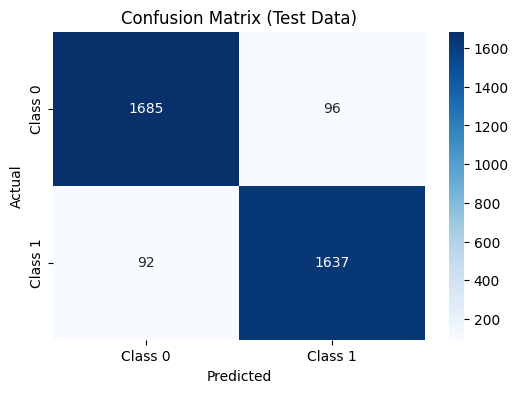

In [14]:
from sklearn.linear_model import LogisticRegression

# Train the model
clf = LogisticRegression(random_state=0).fit(X_train, y_train)

# Predictions for test data
y_pred_test = clf.predict(X_test)

# Predictions for training data
y_pred_train = clf.predict(X_train)

evaluate_model(y_pred_test, y_pred_train)

### Bagging

=== Test Metrics ===
Accuracy: 0.9467236467236467
Precision: 0.9451501154734411
Recall: 0.94679005205321
F1 Score: 0.9459693730135799

=== Training Metrics ===
Accuracy: 0.954050010686044
Precision: 0.9549316054715623
Recall: 0.9523262492820218
F1 Score: 0.9536271478898555

X_train shape: (14037, 30)


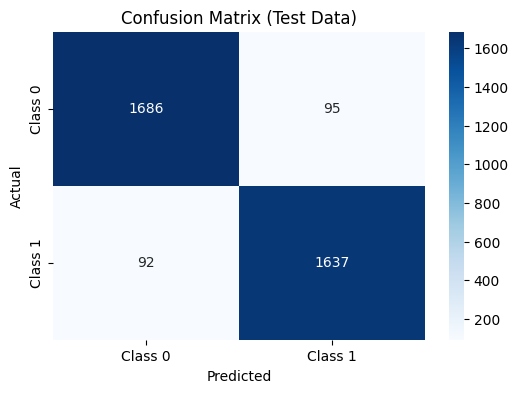

In [15]:
from sklearn.ensemble import BaggingClassifier
# Use logistic model
bagging_clf = BaggingClassifier(estimator=clf, n_estimators=50, random_state=0)
# Train
bagging_clf.fit(X_train, y_train)
# Predict
y_pred_train = bagging_clf.predict(X_train)
y_pred_test = bagging_clf.predict(X_test)
# Evaluate
evaluate_model(y_pred_test, y_pred_train)

### Boosting

=== Test Metrics ===
Accuracy: 0.9193732193732194
Precision: 0.9098639455782312
Recall: 0.9282822440717178
F1 Score: 0.9189808187804179

=== Training Metrics ===
Accuracy: 0.9335328061551613
Precision: 0.9310936383130808
Recall: 0.9352383687535899
F1 Score: 0.9331614012465076

X_train shape: (14037, 30)


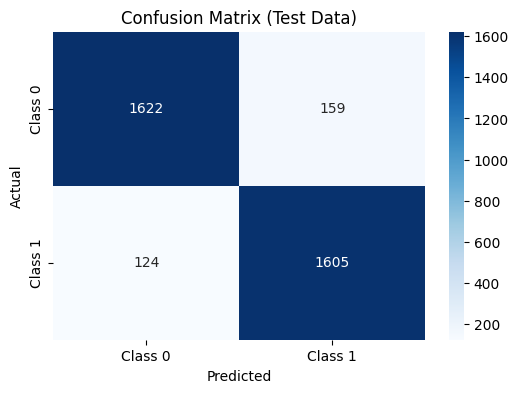

In [16]:
from sklearn.ensemble import AdaBoostClassifier
# Use logistic model 
boosting_clf = AdaBoostClassifier(estimator=clf, n_estimators=100, random_state=0)
# Train
boosting_clf.fit(X_train, y_train)
# Predict
y_pred_train = boosting_clf.predict(X_train)
y_pred_test = boosting_clf.predict(X_test)
# Evaluate
evaluate_model(y_pred_test, y_pred_train)

## Wrapper Method
running the RFE wrapper method recursively until the percision value begins decreasing from the elimination of Features within the dataset

In [17]:
removed, remaining, final_f1 = iterative_feature_elimination(
    clf=clf,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    feature_names=df.drop(columns=['winner']).columns.tolist()
)

Baseline F1: 0.9457
Removed 'p2_ht' → new F1 = 0.9463
Removed 'p1_rank' → new F1 = 0.9457
Removed 'p1_age' → new F1 = 0.9465
Removed 'p2_rank_points' → new F1 = 0.9463
Removed 'surface' → new F1 = 0.9463
Removed 'p1_hand' → new F1 = 0.9463
Removed 'p1_rank_points' → new F1 = 0.9457
→ Stopping: dropping 'p1_ht' drops F1 from 0.9457 to 0.9455

Total removed: 8 features
Features removed (in order):
 - p2_ht
 - p1_rank
 - p1_age
 - p2_rank_points
 - surface
 - p1_hand
 - p1_rank_points
 - p1_ht


## DecisionTreeClassifier

=== Test Metrics ===
Accuracy: 0.7774928774928775
Precision: 0.7907975460122699
Recall: 0.7455176402544823
F1 Score: 0.7674903245013397

=== Training Metrics ===
Accuracy: 0.7777302842487711
Precision: 0.7946948788715118
Recall: 0.7442561746122918
F1 Score: 0.7686489693014978

X_train shape: (14037, 30)


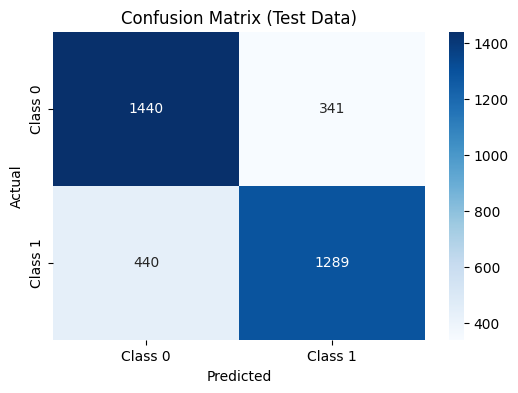

In [18]:
from sklearn.tree import DecisionTreeClassifier

# Train the model
clf = DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=0)
clf.fit(X_train, y_train)

# Predictions for test data
y_pred_test = clf.predict(X_test)

# Predictions for training data
y_pred_train = clf.predict(X_train)

evaluate_model(y_pred_test, y_pred_train)

### Bagging

=== Test Metrics ===
Accuracy: 0.8168091168091168
Precision: 0.8142361111111112
Recall: 0.8137651821862348
F1 Score: 0.8140005785363031

=== Training Metrics ===
Accuracy: 0.8156301203960961
Precision: 0.8150014396775123
Recall: 0.812894887995405
F1 Score: 0.8139468008626887

X_train shape: (14037, 30)


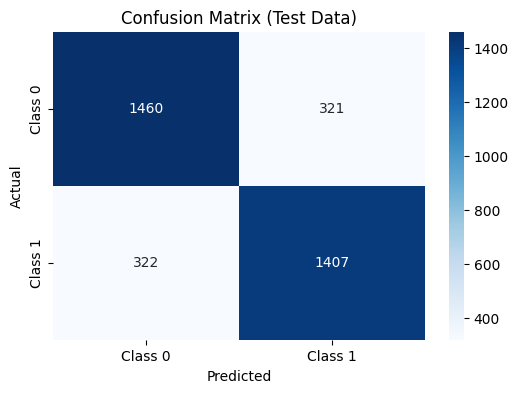

In [19]:
# Use decision tree model
bagging_clf = BaggingClassifier(estimator=clf, n_estimators=50, random_state=0)
# Train
bagging_clf.fit(X_train, y_train)
# Predict
y_pred_train = bagging_clf.predict(X_train)
y_pred_test = bagging_clf.predict(X_test)
# Evaluate
evaluate_model(y_pred_test, y_pred_train)

### Boosting

=== Test Metrics ===
Accuracy: 0.91994301994302
Precision: 0.91324200913242
Recall: 0.9253903990746096
F1 Score: 0.9192760700948004

=== Training Metrics ===
Accuracy: 0.9720025646505663
Precision: 0.9743034502670709
Recall: 0.9691269385410684
F1 Score: 0.9717083003383485

X_train shape: (14037, 30)


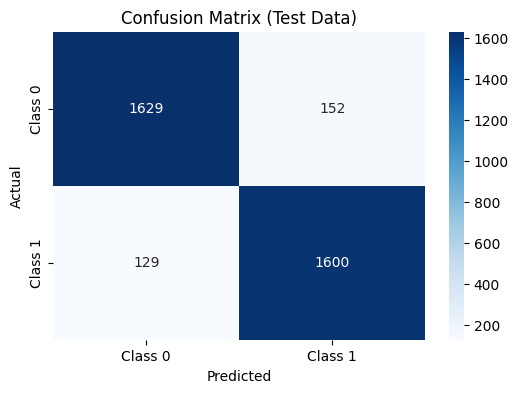

In [20]:
# Use decision tree model
boosting_clf = AdaBoostClassifier(estimator=clf, n_estimators=100, random_state=0)
# Train
boosting_clf.fit(X_train, y_train)
# Predict
y_pred_train = boosting_clf.predict(X_train)
y_pred_test = boosting_clf.predict(X_test)
# Evaluate
evaluate_model(y_pred_test, y_pred_train)

## Wrapper Methods

In [21]:
removed, remaining, final_f1 = iterative_feature_elimination(
    clf=clf,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    feature_names=df.drop(columns=['winner']).columns.tolist()
)

Baseline F1: 0.7675
Removed 'surface' → new F1 = 0.7675
Removed 'p1_hand' → new F1 = 0.7675
Removed 'p1_ht' → new F1 = 0.7675
Removed 'p1_age' → new F1 = 0.7675
Removed 'p2_hand' → new F1 = 0.7675
Removed 'p2_ht' → new F1 = 0.7675
Removed 'p2_age' → new F1 = 0.7675
Removed 'minutes' → new F1 = 0.7675
Removed 'p1_ace' → new F1 = 0.7675
Removed 'p1_df' → new F1 = 0.7675
Removed 'p1_svpt' → new F1 = 0.7675
Removed 'p1_1stIn' → new F1 = 0.7675
Removed 'p1_2ndWon' → new F1 = 0.7675
Removed 'p1_SvGms' → new F1 = 0.7675
Removed 'p2_ace' → new F1 = 0.7675
Removed 'p2_df' → new F1 = 0.7675
Removed 'p2_svpt' → new F1 = 0.7675
Removed 'p2_1stIn' → new F1 = 0.7675
Removed 'p2_SvGms' → new F1 = 0.7675
Removed 'p1_rank' → new F1 = 0.7675
Removed 'p1_rank_points' → new F1 = 0.7675
Removed 'p2_rank' → new F1 = 0.7675
Removed 'p2_rank_points' → new F1 = 0.7675
Removed 'p2_2ndWon' → new F1 = 0.7675
Removed 'p2_bpSaved' → new F1 = 0.7675
→ Stopping: dropping 'p1_bpSaved' drops F1 from 0.7675 to 0.7589

T

## Random Forest

=== Test Metrics ===
Accuracy: 0.8660968660968661
Precision: 0.8624064478986759
Recall: 0.8663967611336032
F1 Score: 0.864396999422966

=== Training Metrics ===
Accuracy: 0.9348863717318515
Precision: 0.9370124241548685
Recall: 0.9313612866168869
F1 Score: 0.9341783090882904

X_train shape: (14037, 30)


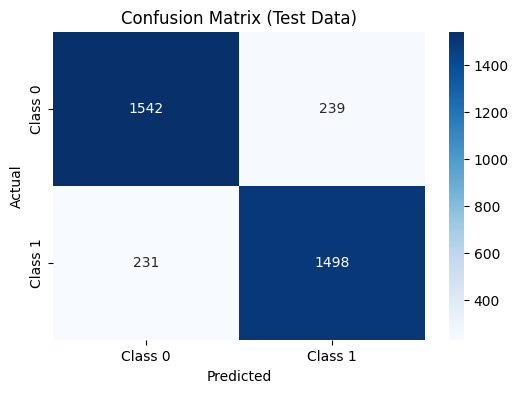

In [22]:
from sklearn.ensemble import RandomForestClassifier

# Train the model
clf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0)
clf.fit(X_train, y_train)

# Predictions
y_pred_test = clf.predict(X_test)
y_pred_train = clf.predict(X_train)

evaluate_model(y_pred_test, y_pred_train)

### Bagging

=== Test Metrics ===
Accuracy: 0.8698005698005699
Precision: 0.8663594470046083
Recall: 0.869866975130133
F1 Score: 0.8681096681096682

=== Training Metrics ===
Accuracy: 0.9261950559236304
Precision: 0.9285714285714286
Recall: 0.9221711659965537
F1 Score: 0.9253602305475505

X_train shape: (14037, 30)


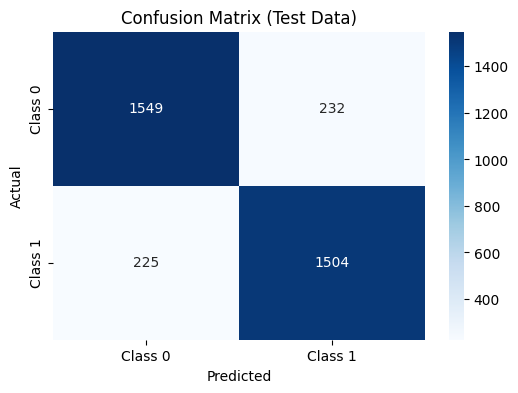

In [23]:
# Use random forest model
bagging_clf = BaggingClassifier(estimator=clf, random_state=0)
# Train
bagging_clf.fit(X_train, y_train)
# Predict
y_pred_train = bagging_clf.predict(X_train)
y_pred_test = bagging_clf.predict(X_test)
# Evaluate
evaluate_model(y_pred_test, y_pred_train)

### Boosting

=== Test Metrics ===
Accuracy: 0.8962962962962963
Precision: 0.8988895382817066
Recall: 0.8895315211104685
F1 Score: 0.8941860465116279

=== Training Metrics ===
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

X_train shape: (14037, 30)


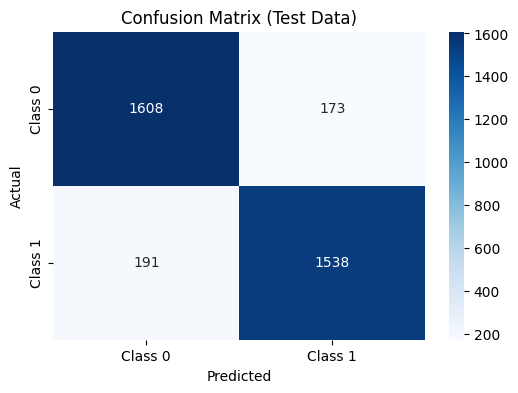

In [24]:
# Use random forest model
boosting_clf = AdaBoostClassifier(estimator=clf, n_estimators=15, random_state=0)
# Train
boosting_clf.fit(X_train, y_train)
# Predict
y_pred_train = boosting_clf.predict(X_train)
y_pred_test = boosting_clf.predict(X_test)
# Evaluate
evaluate_model(y_pred_test, y_pred_train)

## Wrapper Methods

In [25]:
baseline_f1 = f1_score(y_test, clf.predict(X_test))
print(f"Baseline F1: {baseline_f1:.4f}")

# 2. Grab your feature names so we can report them
feature_names = df.drop(columns=['winner']).columns.tolist()

# 3. Prepare working copies of X and feature list
current_X_train = X_train.copy()
current_X_test  = X_test.copy()
features = feature_names.copy()
removed_features = []

# 4. Iteratively drop one feature at a time
while True:
    # build an RFE selector that will drop exactly one feature
    selector = RFE(estimator=clf, n_features_to_select=len(features) - 1)
    selector.fit(current_X_train, y_train)

    # evaluate F1 after dropping that one feature
    new_f1 = f1_score(y_test, selector.predict(current_X_test))
    # find which feature was dropped
    dropped_idx  = np.where(~selector.support_)[0][0]
    dropped_feat = features[dropped_idx]

    # if performance falls off, record and stop
    if new_f1 < baseline_f1:
        removed_features.append(dropped_feat)
        print(f"→ Stopping: dropping '{dropped_feat}' drops F1 from {baseline_f1:.4f} to {new_f1:.4f}")
        break

    # otherwise, record removal and continue
    removed_features.append(dropped_feat)
    print(f"Removed '{dropped_feat}' → new F1 = {new_f1:.4f}")

    # update feature list and training/testing matrices
    features.pop(dropped_idx)
    current_X_train = current_X_train[:, selector.support_]
    current_X_test  = current_X_test[:, selector.support_]

# 5. Summary of all dropped features
print(f"\nTotal removed: {len(removed_features)} features")
print("Features removed (in order):")
for feat in removed_features:
    print(f" - {feat}")

Baseline F1: 0.8644
→ Stopping: dropping 'p1_hand' drops F1 from 0.8644 to 0.8636

Total removed: 1 features
Features removed (in order):
 - p1_hand


## KNN

=== Test Metrics ===
Accuracy: 0.8245014245014245
Precision: 0.8185460789925587
Recall: 0.8270676691729323
F1 Score: 0.8227848101265823

=== Training Metrics ===
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

X_train shape: (14037, 30)


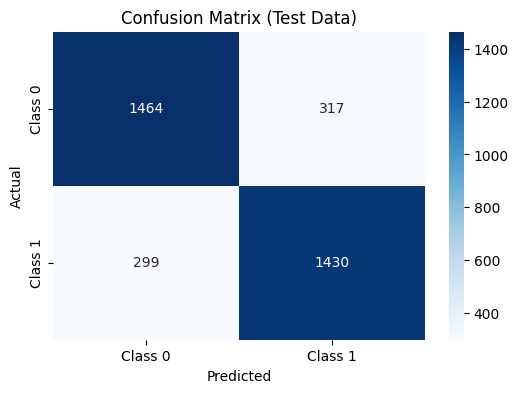

In [26]:
from sklearn.neighbors import KNeighborsClassifier

# Initialize and fit the model
neigh = KNeighborsClassifier(n_neighbors=100, weights='distance', algorithm='auto')
neigh.fit(X_train, y_train)

# Predictions
y_pred_test = neigh.predict(X_test)
y_pred_train = neigh.predict(X_train)

evaluate_model(y_pred_test, y_pred_train)

### Bagging

=== Test Metrics ===
Accuracy: 0.8698005698005699
Precision: 0.8663594470046083
Recall: 0.869866975130133
F1 Score: 0.8681096681096682

=== Training Metrics ===
Accuracy: 0.9261950559236304
Precision: 0.9285714285714286
Recall: 0.9221711659965537
F1 Score: 0.9253602305475505

X_train shape: (14037, 30)


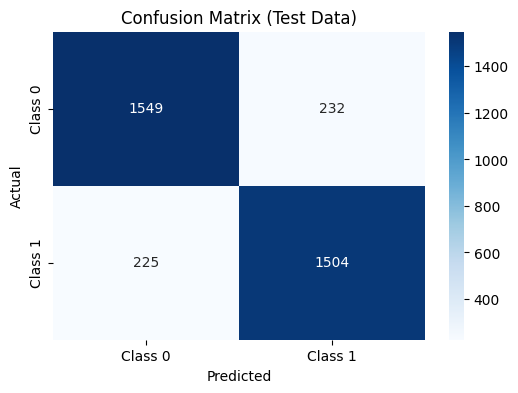

In [27]:
# Use KNN model
bagging_clf = BaggingClassifier(estimator=clf, random_state=0)
# Train
bagging_clf.fit(X_train, y_train)
# Predict
y_pred_train = bagging_clf.predict(X_train)
y_pred_test = bagging_clf.predict(X_test)
# Evaluate
evaluate_model(y_pred_test, y_pred_train)

### Boosting

=== Test Metrics ===
Accuracy: 0.8962962962962963
Precision: 0.8988895382817066
Recall: 0.8895315211104685
F1 Score: 0.8941860465116279

=== Training Metrics ===
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

X_train shape: (14037, 30)


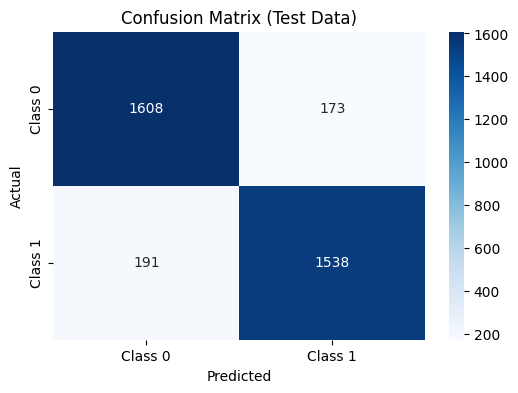

In [28]:
# Use KNN model
boosting_clf = AdaBoostClassifier(estimator=clf, n_estimators=15, random_state=0)
# Train
boosting_clf.fit(X_train, y_train)
# Predict
y_pred_train = boosting_clf.predict(X_train)
y_pred_test = boosting_clf.predict(X_test)
# Evaluate
evaluate_model(y_pred_test, y_pred_train)

## Wrapper Method

In [29]:
removed, remaining, final_f1 = iterative_feature_elimination(
    clf=clf,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    feature_names=df.drop(columns=['winner']).columns.tolist()
)

Baseline F1: 0.8644
→ Stopping: dropping 'p1_hand' drops F1 from 0.8644 to 0.8636

Total removed: 1 features
Features removed (in order):
 - p1_hand


## SVM Linear Kernel

=== Test Metrics ===
Accuracy: 0.947008547008547
Precision: 0.9451817657241778
Recall: 0.9473684210526315
F1 Score: 0.9462738301559792

=== Training Metrics ===
Accuracy: 0.9544774524471041
Precision: 0.9541864139020537
Recall: 0.9540493968983343
F1 Score: 0.9541179004810799

X_train shape: (14037, 30)


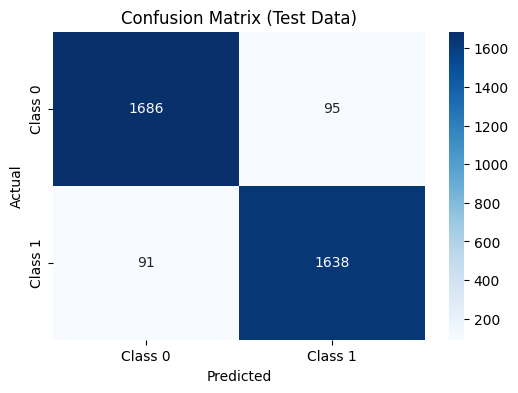

In [30]:
from sklearn.svm import LinearSVC

# Train the model
clf = LinearSVC(random_state=0, tol=1e-5, C=1.0)
clf.fit(X_train, y_train)

# Predictions
y_pred_test = clf.predict(X_test)
y_pred_train = clf.predict(X_train)

evaluate_model(y_pred_test, y_pred_train)

### Bagging

=== Test Metrics ===
Accuracy: 0.9478632478632478
Precision: 0.9463048498845266
Recall: 0.9479467900520532
F1 Score: 0.9471251083501878

=== Training Metrics ===
Accuracy: 0.9542637315665741
Precision: 0.9541666666666667
Recall: 0.9536186099942562
F1 Score: 0.9538925596093076

X_train shape: (14037, 30)


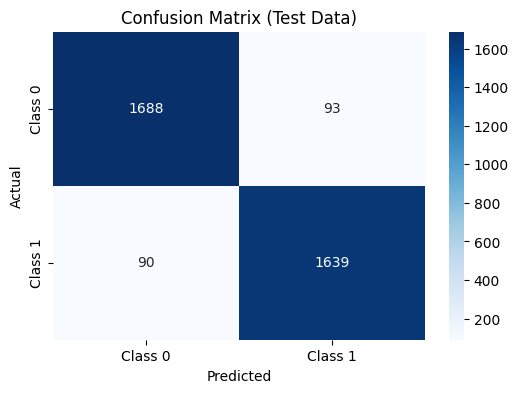

In [31]:
# Use linear SVM model
bagging_clf = BaggingClassifier(estimator=clf, n_estimators=50, random_state=0)
# Train
bagging_clf.fit(X_train, y_train)
# Predict
y_pred_train = bagging_clf.predict(X_train)
y_pred_test = bagging_clf.predict(X_test)
# Evaluate
evaluate_model(y_pred_test, y_pred_train)

### Boosting

=== Test Metrics ===
Accuracy: 0.9250712250712251
Precision: 0.9296600234466589
Recall: 0.9172932330827067
F1 Score: 0.9234352256186318

=== Training Metrics ===
Accuracy: 0.9338177673292014
Precision: 0.9401896425966448
Recall: 0.925473865594486
F1 Score: 0.9327737173456835

X_train shape: (14037, 30)


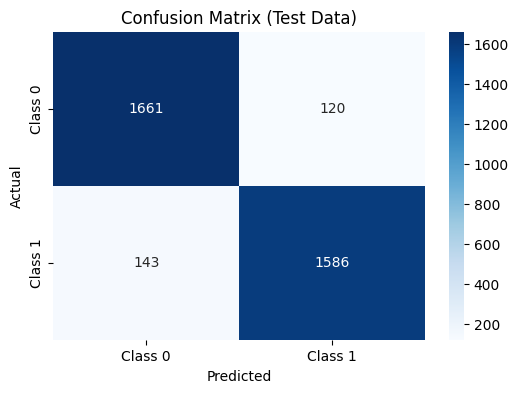

In [32]:
# Use linear SVM model
boosting_clf = AdaBoostClassifier(estimator=clf, n_estimators=100, random_state=0)
# Train
boosting_clf.fit(X_train, y_train)
# Predict
y_pred_train = boosting_clf.predict(X_train)
y_pred_test = boosting_clf.predict(X_test)
# Evaluate
evaluate_model(y_pred_test, y_pred_train)

## Wrapper Method

In [33]:
removed, remaining, final_f1 = iterative_feature_elimination(
    clf=clf,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    feature_names=df.drop(columns=['winner']).columns.tolist()
)

Baseline F1: 0.9463
Removed 'p2_df' → new F1 = 0.9463
Removed 'p1_rank' → new F1 = 0.9466
Removed 'p2_SvGms' → new F1 = 0.9463
Removed 'p1_age' → new F1 = 0.9463
→ Stopping: dropping 'surface' drops F1 from 0.9463 to 0.9460

Total removed: 5 features
Features removed (in order):
 - p2_df
 - p1_rank
 - p2_SvGms
 - p1_age
 - surface


## SVM Gaussian Kernel

=== Test Metrics ===
Accuracy: 0.9347578347578348
Precision: 0.9335260115606936
Recall: 0.9340659340659341
F1 Score: 0.9337958947672738

=== Training Metrics ===
Accuracy: 0.9630975279618152
Precision: 0.9648110758580906
Recall: 0.9606547960941987
F1 Score: 0.9627284501367103

X_train shape: (14037, 30)


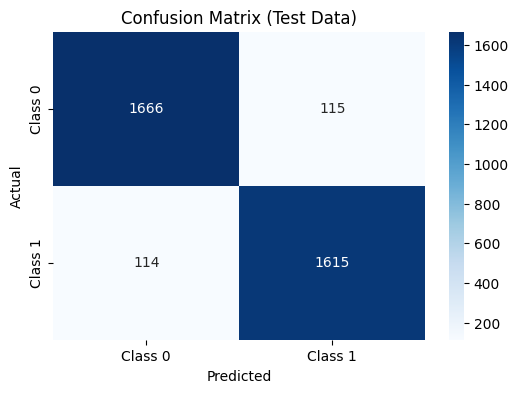

In [34]:
from sklearn.svm import SVC

# Train the model
clf = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=0)
clf.fit(X_train, y_train)

# Make predictions
y_pred_test = clf.predict(X_test)
y_pred_train = clf.predict(X_train)

evaluate_model(y_pred_test, y_pred_train)

### Bagging

=== Test Metrics ===
Accuracy: 0.933903133903134
Precision: 0.9334105385060799
Recall: 0.9323308270676691
F1 Score: 0.9328703703703703

=== Training Metrics ===
Accuracy: 0.961530241504595
Precision: 0.9659123875834058
Recall: 0.9562033314187248
F1 Score: 0.9610333381440324

X_train shape: (14037, 30)


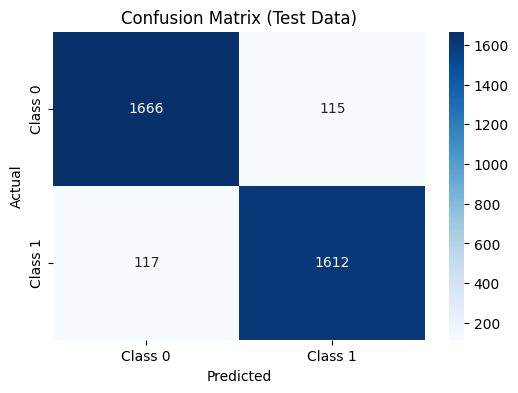

In [35]:
# Use gaussian SVM model
bagging_clf = BaggingClassifier(estimator=clf, random_state=0)
# Train
bagging_clf.fit(X_train, y_train)
# Predict
y_pred_train = bagging_clf.predict(X_train)
y_pred_test = bagging_clf.predict(X_test)
# Evaluate
evaluate_model(y_pred_test, y_pred_train)

# Note: Boosting results in the model predicting all 1s

## Stacking

### Decision Tree, KNN, & Random Forest -> Logistic

=== Test Metrics ===
Accuracy: 0.8740740740740741
Precision: 0.8696151636990236
Recall: 0.8756506651243493
F1 Score: 0.8726224783861671

=== Training Metrics ===
Accuracy: 0.991949846833369
Precision: 0.9925233644859813
Recall: 0.991240666283745
F1 Score: 0.9918816006897048

X_train shape: (14037, 30)


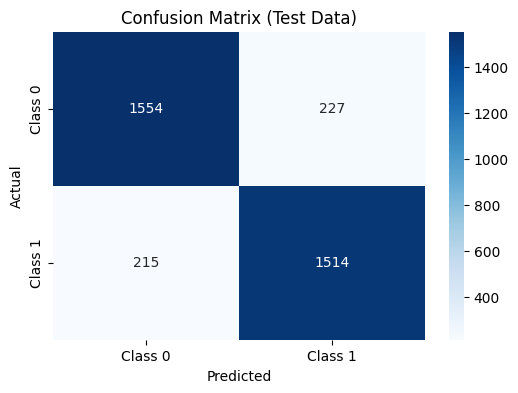

In [37]:
from sklearn.ensemble import StackingClassifier
estimators = [
  ["DecisionTreeClassifier", DecisionTreeClassifier(criterion='entropy', random_state=0)],
  ["KNeighborsClassifier", KNeighborsClassifier(n_neighbors=100, weights='distance')],
  ["RandomForestClassifier", RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0)]
]
stacking_clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(random_state=0))
# Train
stacking_clf.fit(X_train, y_train)
# Predict
y_pred_train = stacking_clf.predict(X_train)
y_pred_test = stacking_clf.predict(X_test)
# Evaluate
evaluate_model(y_pred_test, y_pred_train)

### Logistic & KNN -> Decision Tree

=== Test Metrics ===
Accuracy: 0.9193732193732194
Precision: 0.9179190751445087
Recall: 0.91844997108155
F1 Score: 0.9181844463717838

=== Training Metrics ===
Accuracy: 0.9213507159649498
Precision: 0.9349762470308789
Recall: 0.9043653072946582
F1 Score: 0.9194160583941606

X_train shape: (14037, 30)


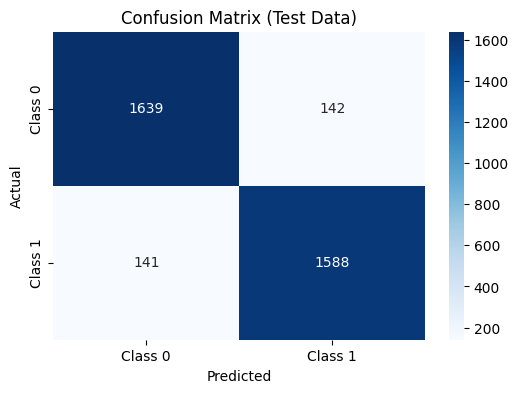

In [38]:
estimators = [
  ["LogisticRegression", LogisticRegression(random_state=0)],
  ["KNeighborsClassifier", KNeighborsClassifier(n_neighbors=100, weights='distance')]
]
stacking_clf = StackingClassifier(estimators=estimators, final_estimator=DecisionTreeClassifier(random_state=0))
# Train
stacking_clf.fit(X_train, y_train)
# Predict
y_pred_train = stacking_clf.predict(X_train)
y_pred_test = stacking_clf.predict(X_test)
# Evaluate
evaluate_model(y_pred_test, y_pred_train)

### Gaussian SVC & Decision Tree -> Logistic

=== Test Metrics ===
Accuracy: 0.9344729344729344
Precision: 0.9329867128827267
Recall: 0.9340659340659341
F1 Score: 0.9335260115606936

=== Training Metrics ===
Accuracy: 0.9639524114839353
Precision: 0.9650057603686636
Recall: 0.9622343480758185
F1 Score: 0.9636180615473109

X_train shape: (14037, 30)


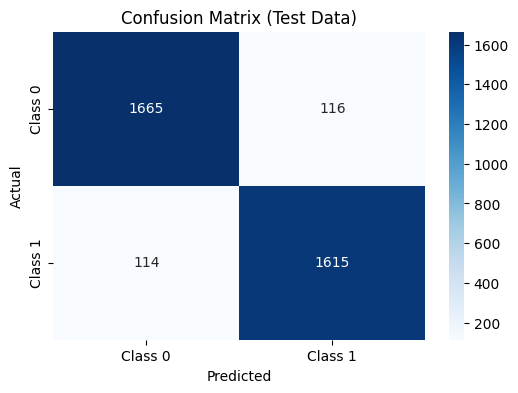

In [39]:
estimators = [
  ["SVC", SVC(kernel='rbf', C=1.0, gamma='scale', random_state=0)],
  ["DecisionTreeClassifier", DecisionTreeClassifier(criterion='entropy', random_state=0)]
]
stacking_clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(random_state=0))
# Train
stacking_clf.fit(X_train, y_train)
# Predict
y_pred_train = stacking_clf.predict(X_train)
y_pred_test = stacking_clf.predict(X_test)
# Evaluate
evaluate_model(y_pred_test, y_pred_train)

## KNN With HyperTuning

In [ ]:
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.model_selection import GridSearchCV
# import pandas as pd

# param_grid = {
#     "n_neighbors": [100, 200],
#     "weights":     ["uniform", "distance"],
#     "metric":      ["euclidean", "manhattan"],
#     "algorithm":   ["auto", "kd_tree", "ball_tree"]
# }

# grid_knn = GridSearchCV(
#     estimator   = KNeighborsClassifier(),
#     param_grid  = param_grid,
#     scoring     = "balanced_accuracy",
#     verbose     = 0
# )

# grid_knn.fit(X_train, y_train)

# print("Best hyper‑parameters:", grid_knn.best_params_)
# print(f"Best score (train only): {grid_knn.best_score_:.4f}")

# best_knn      = grid_knn.best_estimator_
# y_pred_test   = best_knn.predict(X_test)
# y_pred_train  = best_knn.predict(X_train)

# # Custom evaluation
# evaluate_model(y_pred_test, y_pred_train)

# results = pd.DataFrame(grid_knn.cv_results_)
# top5 = results.sort_values(by="mean_test_score", ascending=False).head()

# print("Top 5 configs:")
# print(top5[["params", "mean_test_score"]])

## DecisionTreeClassifier with Hypertuning

In [ ]:
# from sklearn.tree import DecisionTreeClassifier

# dt_manual = DecisionTreeClassifier(
#     criterion="entropy",
#     max_depth=10,
#     min_samples_split=10,
#     min_samples_leaf=5,
#     class_weight="balanced",
#     random_state=42
# )
# dt_manual.fit(X_train, y_train)

# y_pred_test  = dt_manual.predict(X_test)
# y_pred_train = dt_manual.predict(X_train)

# evaluate_model(y_pred_test, y_pred_train)

## Logistic Regression With Hypertuning

In [ ]:
# # Tried on this one but not much change, running gridsearch on all will blow up our computers

# # testing elastic 
# from sklearn.linear_model import LogisticRegression

# log_manual = LogisticRegression(
#     penalty="elasticnet",
#     C=1.0,
#     l1_ratio=0.5,
#     class_weight="balanced",
#     solver="saga",
#     max_iter=10000,
#     random_state=42
# )
# log_manual.fit(X_train, y_train)

# y_pred_test  = log_manual.predict(X_test)
# y_pred_train = log_manual.predict(X_train)

# evaluate_model(y_pred_test, y_pred_train)